In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
!unzip -qq ./chip_data.zip -d data

In [7]:
dataset_path = "./data/dataset/"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [8]:
def show_sample_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(5, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0)  # Convert tensor format (C, H, W) to (H, W, C)
        axes[i].imshow(image)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis("off")
    plt.show()

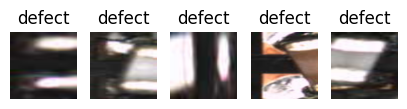

In [9]:
show_sample_images(train_dataset)

In [10]:
# Get the total number of samples in the training dataset
print(f"Total number of training samples: {len(train_dataset)}")

# Get the shape of the first image in the dataset
first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total number of training samples: 172
Shape of the first image: torch.Size([3, 224, 224])


In [11]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [13]:
from torchvision.models import VGG19_Weights
model1 = models.vgg19(weights=VGG19_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 76.3MB/s]


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

In [15]:
from torchsummary import summary
# Print model summary
summary(model1, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [17]:
num_classes=len(train_dataset.classes)
in_features=model1.classifier[-1].in_features
model1.classifier[-1]=nn.Linear(in_features,num_classes)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

In [19]:
summary(model1, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [20]:
for param in model1.features.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.classifier.parameters(), lr=0.001)

In [22]:
def train_model(model, train_loader,test_loader,num_epochs=10):
    train_losses = []
    val_losses = []
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        # Compute validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(test_loader))
        model.train()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    # Plot training and validation loss
    print("Name: SREE NIVEDITAA SARAVANAN")
    print("Register Number: 212223230213")
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = model1.to(device)

Epoch [1/10], Train Loss: 0.6170, Validation Loss: 1.8733
Epoch [2/10], Train Loss: 0.0145, Validation Loss: 0.6578
Epoch [3/10], Train Loss: 0.5554, Validation Loss: 2.2296
Epoch [4/10], Train Loss: 0.3300, Validation Loss: 0.6751
Epoch [5/10], Train Loss: 0.0408, Validation Loss: 5.5365
Epoch [6/10], Train Loss: 0.1838, Validation Loss: 0.7860
Epoch [7/10], Train Loss: 0.2129, Validation Loss: 5.9353
Epoch [8/10], Train Loss: 0.1727, Validation Loss: 1.6754
Epoch [9/10], Train Loss: 0.0000, Validation Loss: 0.6805
Epoch [10/10], Train Loss: 0.0795, Validation Loss: 1.9153
Name: SREE NIVEDITAA SARAVANAN
Register Number: 212223230213


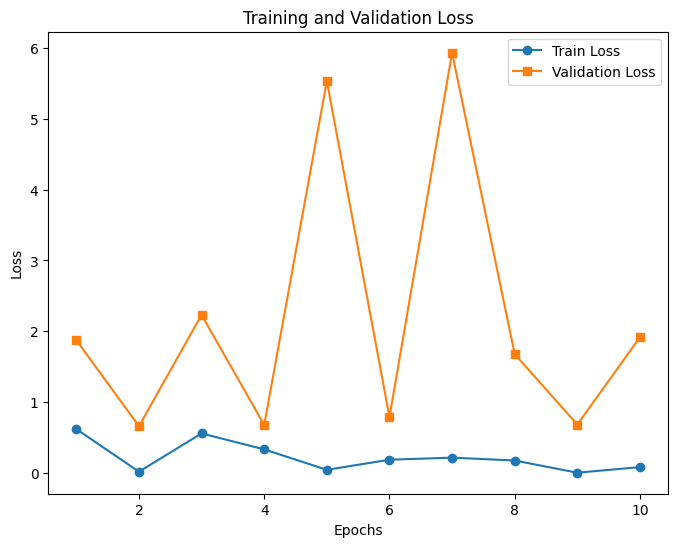

In [25]:
train_model(model1,train_loader,test_loader,num_epochs=10)

In [1]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f'Test Accuracy: {accuracy:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Name:        ")
    print("Register Number:        ")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report
    print("Name:        ")
    print("Register Number:        ")
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Test Accuracy: 0.9504
Name:        
Register Number:        


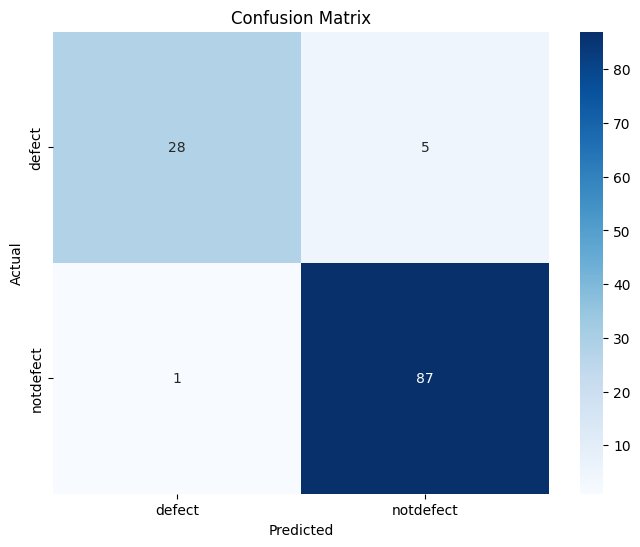

Name:        
Register Number:        
Classification Report:
              precision    recall  f1-score   support

      defect       0.97      0.85      0.90        33
   notdefect       0.95      0.99      0.97        88

    accuracy                           0.95       121
   macro avg       0.96      0.92      0.93       121
weighted avg       0.95      0.95      0.95       121



In [26]:
test_model(model1,test_loader)

In [27]:
def predict_image(model, image_index, dataset):
    model.eval()
    image, label = dataset[image_index]
    with torch.no_grad():
        # The image is already a tensor, just add batch dimension and send to device
        image_tensor = image.unsqueeze(0).to(device)
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    class_names = dataset.classes  # Get class labels

    # Display the image
    # Need to convert the image back to PIL format for display
    image_to_display = transforms.ToPILImage()(image)
    print("Name: SREE NIVEDITAA SARAVANAN")
    print("Register Number:  212223230213")
    plt.figure(figsize=(4, 4))
    plt.imshow(image_to_display)
    plt.title(f'Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}')
    plt.axis("off")
    plt.show()

Name: Abdur Rahman Basil A H
Register Number:  212223040002


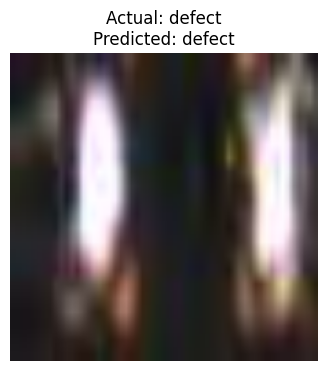

In [30]:
predict_image(model1, image_index=14, dataset=test_dataset)